In [18]:
# Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
from firedrake import *
from tqdm.auto import tqdm
from numpy.random import default_rng
import matplotlib.pyplot as plt
from firedrake.meshadapt import *
import time

In [19]:
from firedrake import Constant, cos, sin, Function, SpatialCoordinate, sqrt
from firedrake import assemble, FacetNormal, avg, jump,pi
from firedrake.cython.dmcommon import create_section
import movement.solver_parameters as solver_parameters
from firedrake.petsc import PETSc
from pyadjoint import no_annotations
import ufl
import numpy as np
import matplotlib.pyplot as plt

    Residual norms for firedrake_255_ solve.
    0 KSP Residual norm 2.180790185361e+01 
    1 KSP Residual norm 7.684600965018e+00 
    2 KSP Residual norm 4.343550121007e+00 
    3 KSP Residual norm 3.015354566945e+00 
    4 KSP Residual norm 2.332171217000e+00 
    5 KSP Residual norm 1.907167916305e+00 
    6 KSP Residual norm 1.600879638087e+00 
    7 KSP Residual norm 1.378262622376e+00 
    8 KSP Residual norm 1.217855700069e+00 
    9 KSP Residual norm 1.090096238987e+00 
   10 KSP Residual norm 9.825783842878e-01 
   11 KSP Residual norm 8.961985613689e-01 
   12 KSP Residual norm 8.260039465686e-01 
   13 KSP Residual norm 7.644596577453e-01 
   14 KSP Residual norm 7.111627272960e-01 
   15 KSP Residual norm 6.662200835902e-01 
   16 KSP Residual norm 6.256172980358e-01 
   17 KSP Residual norm 5.882597988913e-01 
   18 KSP Residual norm 5.559012959443e-01 
   19 KSP Residual norm 5.273709333833e-01 
   20 KSP Residual norm 5.009127762442e-01 
   21 KSP Residual norm 4.77214

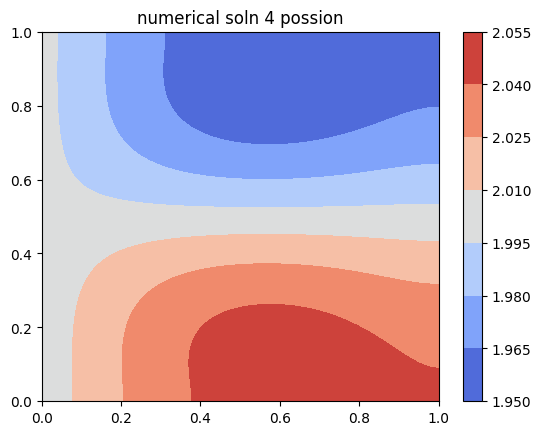

In [20]:
# Define mesh and function space
mesh = UnitSquareMesh(128, 128)
P1 = FunctionSpace(mesh, 'CG', 1)
P1_vec = VectorFunctionSpace(mesh, 'CG', 1)

x, y = SpatialCoordinate(mesh)

u = TrialFunction(P1)
v = TestFunction(P1)

a = inner(grad(u), grad(v)) * dx

x = SpatialCoordinate(mesh)
F = Function(P1)
F.interpolate(sin(x[0]*pi)*sin(2*x[1]*pi))
L = F*v*dx

bcs = [DirichletBC(P1, Constant(2.0), (1,))]

uu = Function(P1)
uu.assign(0)
solve(a == L, uu, bcs=bcs, solver_parameters={"mat_type": "matfree",
                                              "ksp_type": "cg",
                                              "ksp_monitor": None,
                                              "pc_type": "python",
                                                "pc_python_type": "firedrake.AssembledPC",
                                                "assembled_pc_type": "ilu"})


fig, axes = plt.subplots()
u_numerical_plt = tricontourf(uu, axes=axes, cmap='coolwarm')
fig.colorbar(u_numerical_plt ,ax = axes)
plt.title("numerical soln 4 possion")
plt.show()

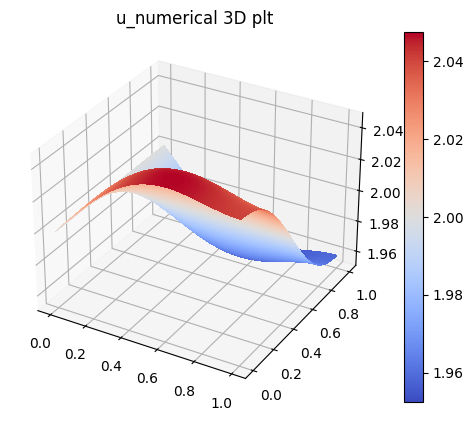

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u_num_plt = trisurf(uu, axes=ax, cmap='coolwarm')
fig.colorbar(u_num_plt,ax = ax)
plt.title("u_numerical 3D plt")
plt.show()

In [22]:
#doing modification for monge_ampere move:
class PrimeMover(object):
    """
    Base class for all mesh movers.
    """
    def __init__(self, mesh, monitor_function=None, **kwargs):
        self.mesh = mesh
        self.monitor_function = monitor_function
        self.dim = mesh.topological_dimension()
        if self.dim != 2:
            raise NotImplementedError(f"Dimension {self.dim} has not been considered yet")
        self.gdim = mesh.geometric_dimension()
        self.plex = self.mesh.topology_dm
        self.vertex_indices = self.plex.getDepthStratum(0)
        self.edge_indices = self.plex.getDepthStratum(1)

        # Measures
        degree = kwargs.get('quadrature_degree')
        self.dx = dx(domain=mesh, degree=degree)
        self.ds = ds(domain=mesh, degree=degree)
        self.dS = dS(domain=mesh, degree=degree)

        # Mesh coordinate functions
        self.coord_space = mesh.coordinates.function_space()
        # Mesh coordinate functions comment:下面的 self.xi 是不会发生变化的，所以叫 Computational coordinates
        self._x = Function(mesh.coordinates, name="Physical coordinates")
        self.xi = Function(mesh.coordinates, name="Computational coordinates")
        self.v = Function(self.coord_space, name="Mesh velocity")

    def _get_coordinate_section(self):
        entity_dofs = np.zeros(self.dim+1, dtype=np.int32)
        entity_dofs[0] = self.gdim
        self._coordinate_section = create_section(self.mesh, entity_dofs)
        dm_coords = self.plex.getCoordinateDM()
        dm_coords.setDefaultSection(self._coordinate_section)
        self._coords_local_vec = dm_coords.createLocalVec()
        self._update_plex_coordinates()

    def _update_plex_coordinates(self):
        if not hasattr(self, '_coords_local_vec'):
            self._get_coordinate_section()
        self._coords_local_vec.array[:] = np.reshape(
            self.mesh.coordinates.dat.data_with_halos,
            self._coords_local_vec.array.shape,
        )
        self.plex.setCoordinatesLocal(self._coords_local_vec)

    def _get_edge_vector_section(self):
        entity_dofs = np.zeros(self.dim+1, dtype=np.int32)
        entity_dofs[1] = 1
        self._edge_vector_section = create_section(self.mesh, entity_dofs)

    def coordinate_offset(self, index):
        """
        Get the DMPlex coordinate section offset
        for a given `index`.
        """
        if not hasattr(self, '_coordinate_section'):
            self._get_coordinate_section()
        return self._coordinate_section.getOffset(index)//self.dim

    def edge_vector_offset(self, index):
        """
        Get the DMPlex edge vector section offset
        for a given `index`.
        """
        if not hasattr(self, '_edge_vector_section'):
            self._get_edge_vector_section()
        return self._edge_vector_section.getOffset(index)

    def coordinate(self, index):
        """
        Get the mesh coordinate associated with
        a given `index`.
        """
        return self.mesh.coordinates.dat.data_with_halos[self.get_offset(index)]

    def move(self):
        """
        Move the mesh according to the method of choice.
        """
        raise NotImplementedError("Implement `move` in the derived class.")

    def adapt(self):
        """
        Alias of `move`.
        """
        from warnings import warn
        warn("`adapt` is deprecated (use `move` instead)", DeprecationWarning, stacklevel=2)
        return self.move()


In [23]:
class MongeAmpereMover_Base(PrimeMover):
    """
    Base class for mesh movers based on the solution
    of Monge-Ampere type equations.
    """
    residual_l2_form = 0
    norm_l2_form = 0
    phi_old = None

    def __init__(self, mesh, monitor_function, u, **kwargs):
        """
        :arg mesh: the physical mesh
        :arg monitor_function: a Python function which takes a mesh as input
        :kwarg phi_init: initial guess for the scalar potential
        :kwarg sigma_init: initial guess for the Hessian
        :kwarg maxiter: maximum number of iterations for the relaxation
        :kwarg rtol: relative tolerance for the residual
        :kwarg dtol: divergence tolerance for the residual
        :kwarg fix_boundary_nodes: should all boundary nodes remain fixed?
        """
        if monitor_function is None:
            raise ValueError("Please supply a monitor function")

        #add u
        self.u = u
        
        # Collect parameters before calling super
        self.pseudo_dt = Constant(kwargs.pop('pseudo_timestep', 0.1))
        self.maxiter = kwargs.pop('maxiter', 1000)
        self.rtol = kwargs.pop('rtol', 1e-3)
        self.dtol = kwargs.pop('dtol', 2.0)
        self.fix_boundary_nodes = kwargs.pop('fix_boundary_nodes', False)
        super().__init__(mesh, monitor_function = monitor_function)

        # Create function spaces
        self.P0 = FunctionSpace(mesh, "DG", 0)
        self.P1 = FunctionSpace(mesh, "CG", 1)
        self.P1_vec = VectorFunctionSpace(mesh, "CG", 1)
        self.P1_ten = TensorFunctionSpace(mesh, "CG", 1)

        # Create objects used during the mesh movement
        self.theta = Constant(0.0)
        self.monitor = Function(self.P1, name="Monitor function")
        self.monitor.interpolate(self.monitor_function(self.mesh, self.u))
        self.volume = Function(self.P0, name="Mesh volume")
        self.volume.interpolate(ufl.CellVolume(mesh))
        self.original_volume = Function(self.volume)
        self.total_volume = assemble(Constant(1.0)*self.dx)
        self.L_P0 = TestFunction(self.P0)*self.monitor*self.dx
        self._grad_phi = Function(self.P1_vec)
        self.grad_phi = Function(self.mesh.coordinates)

    @PETSc.Log.EventDecorator("MongeAmpereBase.apply_initial_guess")
    def apply_initial_guess(self, phi_init=None, sigma_init=None, **kwargs):
        """
        Initialise the approximations to the scalar potential
        and its hessian with an initial guess.

        By default, both are initialised to zero, which corresponds
        to the case where the computational and physical meshes
        coincide.

        :kwarg phi_init: initial guess for the scalar potential
        :kwarg sigma_init: initial guess for the Hessian
        """

        if phi_init is not None and sigma_init is not None:
            self.phi.assign(phi_init)
            self.sigma.assign(sigma_init)
            self.phi_old.assign(phi_init)
            self.sigma_old.assign(sigma_init)
        elif phi_init is not None or sigma_init is not None:
            raise ValueError("Need to initialise both phi *and* sigma")

        
    @property
    @PETSc.Log.EventDecorator("MongeAmpereBase.diagnostics")
    def diagnostics(self):
        """
        Compute diagnostics:
          1) the ratio of the smallest and largest element volumes;
          2) equidistribution of elemental volumes;
          3) relative L2 norm residual.
        """
        v = self.volume.vector().gather()
        minmax = v.min()/v.max()
        mean = v.sum()/v.max()
        w = v.copy() - mean
        w *= w
        std = np.sqrt(w.sum()/w.size)
        equi = std/mean
        residual_l2 = assemble(self.residual_l2_form).dat.norm
        norm_l2 = assemble(self.norm_l2_form).dat.norm
        residual_l2_rel = residual_l2/norm_l2
        return minmax, residual_l2_rel, equi

    @property
    @PETSc.Log.EventDecorator("MongeAmpereBase.update_coordinates")
    def x(self):
        """
        Update the coordinate :class:`Function` using
        the recovered gradient.
        """
        try:
            self.grad_phi.assign(self._grad_phi)
        except Exception:
            self.grad_phi.interpolate(self._grad_phi)
        self._x.assign(self.xi + self.grad_phi)  # x = ξ + grad(φ)
        return self._x
    
    @property
    @PETSc.Log.EventDecorator("MongeAmpereBase.create_l2_projector")
    def l2_projector(self):
        if hasattr(self, '_l2_projector'):
            return self._l2_projector
        u_cts = TrialFunction(self.P1_vec)
        v_cts = TestFunction(self.P1_vec)

        # Domain interior
        phi_grad_v_dx = ufl.inner(v_cts, ufl.grad(self.phi_old))*self.dx
        a = ufl.inner(v_cts, u_cts)*self.dx
        L = phi_grad_v_dx

        # Enforce no movement normal to boundary
        n = ufl.FacetNormal(self.mesh)
        bcs = []
        for i in self.mesh.exterior_facets.unique_markers:
            if self.fix_boundary_nodes:
                bcs.append(DirichletBC(self.P1_vec, 0, i))
                continue

            # Check for axis-aligned boundaries
            _n = [assemble(abs(n[j])*self.ds(i)) for j in range(self.dim)]
            if np.allclose(_n, 0.0):
                raise ValueError(f"Invalid normal vector {_n}")
            else:
                if np.isclose(_n[0], 0.0):
                    bcs.append(DirichletBC(self.P1_vec.sub(1), 0, i))
                    continue
                elif np.isclose(_n[1], 0.0):
                    bcs.append(DirichletBC(self.P1_vec.sub(0), 0, i))
                    continue

            a_bc = ufl.dot(v_cts, n)*ufl.dot(u_cts, n)*self.ds
            bcs.append(EquationBC(a_bc == 0, self._grad_phi, i))

            s = ufl.perp(n)
            a_bc = ufl.dot(v_cts, s)*ufl.dot(u_cts, s)*self.ds
            L_bc = ufl.dot(v_cts, s)*phi_grad_v_dx
            bcs.append(EquationBC(a_bc == L_bc, self._grad_phi, i))

        # Create solver
        problem = LinearVariationalProblem(a, L, self._grad_phi, bcs=bcs)
        sp = {
            "ksp_type": "cg",
            "pc_type": "bjacobi",
            "sub_pc_type": "ilu",
        }
        self._l2_projector = LinearVariationalSolver(problem, solver_parameters=sp)
        return self._l2_projector

In [24]:
class MongeAmpereMover_Relaxation(MongeAmpereMover_Base):
    r"""
    The elliptic Monge-Ampere equation is solved in a parabolised
    form using a pseudo-time relaxation,

..  math::
        -\frac\partial{\partial\tau}\Delta\phi = m(x)\det(I + H(\phi)) - \theta,

    where :math:`\tau` is the pseudo-time variable. Forward Euler is
    used for the pseudo-time integration (see McRae et al. 2018 for
    details).
    """
    @PETSc.Log.EventDecorator("MongeAmpereMover.__init__")
    def __init__(self, mesh, monitor_function, u, **kwargs):
        """
        :arg mesh: the physical mesh
        :arg monitor_function: a Python function which takes a mesh as input
        :kwarg phi_init: initial guess for the scalar potential
        :kwarg sigma_init: initial guess for the Hessian
        :kwarg pseudo_timestep: pseudo-timestep to use for the relaxation
        :kwarg maxiter: maximum number of iterations for the relaxation
        :kwarg rtol: relative tolerance for the residual
        :kwarg dtol: divergence tolerance for the residual
        """
        def compute_mesh_spacing():
            # Compute the mesh spacing based on the mesh size
            h = sqrt(1.0 / self.mesh.num_cells())
            return h

        
        super().__init__(mesh, monitor_function = monitor_function, u=u, **kwargs)
        h = compute_mesh_spacing()
        self.pseudo_dt = Constant(kwargs.pop('pseudo_timestep',  0.04))
        # Create functions to hold solution data
        self.phi = Function(self.P1)
        self.sigma = Function(self.P1_ten)
        self.phi_old = Function(self.P1)
        self.sigma_old = Function(self.P1_ten)

        #add u to store the 
        self.u = u
        
        # Initialise phi and sigma
        self.apply_initial_guess(**kwargs)

        # Setup residuals
        I = ufl.Identity(self.dim)
        self.theta_form = self.monitor*ufl.det(I + self.sigma_old)*self.dx
        self.residual = self.monitor*ufl.det(I + self.sigma_old) - self.theta
        psi = TestFunction(self.P1)
        self.residual_l2_form = psi*self.residual*self.dx
        self.norm_l2_form = psi*self.theta*self.dx

    @property
    @PETSc.Log.EventDecorator("MongeAmpereMover.create_pseudotimestepper")
    def pseudotimestepper(self):
        """
        Setup the pseudo-timestepper for the relaxation method.
        """
        if hasattr(self, '_pseudotimestepper'):
            return self._pseudotimestepper
        phi = TrialFunction(self.P1)
        psi = TestFunction(self.P1)
        a = ufl.inner(ufl.grad(psi), ufl.grad(phi))*self.dx
        L = ufl.inner(ufl.grad(psi), ufl.grad(self.phi_old))*self.dx \
            + self.pseudo_dt*psi*self.residual*self.dx
        problem = LinearVariationalProblem(a, L, self.phi)
        sp = {
            "ksp_type": "cg",
            "pc_type": "gamg",
        }
        nullspace = VectorSpaceBasis(constant=True)
        self._pseudotimestepper = LinearVariationalSolver(
            problem, solver_parameters=sp,
            nullspace=nullspace, transpose_nullspace=nullspace,
        )
        return self._pseudotimestepper

    @property
    @PETSc.Log.EventDecorator("MongeAmpereMover.create_equidistributor")
    def equidistributor(self):
        """
        Setup the equidistributor for the relaxation method.
        """
        if hasattr(self, '_equidistributor'):
            return self._equidistributor
        if self.dim != 2:
            raise NotImplementedError  # TODO
        n = ufl.FacetNormal(self.mesh)
        sigma = TrialFunction(self.P1_ten)
        tau = TestFunction(self.P1_ten)
        a = ufl.inner(tau, sigma)*self.dx
        L = -ufl.dot(ufl.div(tau), ufl.grad(self.phi))*self.dx \
            + (tau[0, 1]*n[1]*self.phi.dx(0) + tau[1, 0]*n[0]*self.phi.dx(1))*self.ds
        problem = LinearVariationalProblem(a, L, self.sigma)
        sp = {
            "ksp_type": "cg",
            "pc_type": "bjacobi",
            "sub_pc_type": "ilu",
        }
        self._equidistributor = LinearVariationalSolver(problem, solver_parameters=sp)
        return self._equidistributor

    @PETSc.Log.EventDecorator("MongeAmpereMover.move")
    def move(self):
        """
        Run the relaxation method to convergence and update the mesh.
        """
        for i in range(self.maxiter):

            # lz project
            self.l2_projector.solve()

            # Update mesh coordinates
            self.mesh.coordinates.assign(self.x)

            # Update monitor function
            self.monitor.interpolate(self.monitor_function(self.mesh,self.u))
            assemble(self.L_P0, tensor=self.volume)
            self.volume.interpolate(self.volume / self.original_volume)
            self.mesh.coordinates.assign(self.xi)

            # Evaluate normalisation coefficient
            self.theta.assign(assemble(self.theta_form) / self.total_volume)

            # Check convergence criteria
            minmax, residual, equi = self.diagnostics
            if i == 0:
                initial_norm = residual
            PETSc.Sys.Print(f"{i:4d}"
            f"   Min/Max {minmax:10.4e}"
            f"   Residual {residual:10.4e}"
            f"   Equidistribution {equi:10.4e}")
            if residual < self.rtol:

                PETSc.Sys.Print(f"Converged in {i+1} iterations.")
                break
            if residual > self.dtol*initial_norm:
                raise ConvergenceError(f"Diverged after {i+1} iterations.")
            if i == self.maxiter-1:
                raise ConvergenceError(f"Failed to converge in {i+1} iterations.")

            # Apply pseudotimestepper and equidistributor
            self.pseudotimestepper.solve()
            self.equidistributor.solve()
            self.phi_old.assign(self.phi)
            self.sigma_old.assign(self.sigma)
        self.mesh.coordinates.assign(self.x)
        return i


In [25]:
class MongeAmpereMover_QuasiNewton(MongeAmpereMover_Base):
    r"""
    The elliptic Monge-Ampere equation is solved using a quasi-Newton
    method (see McRae et al. 2018 for details).
    """
    @PETSc.Log.EventDecorator("MongeAmpereMover.__init__")
    def __init__(self, mesh, monitor_function, u, **kwargs):
        """
        :arg mesh: the physical mesh
        :arg monitor_function: a Python function which takes a mesh as input
        :kwarg maxiter: maximum number of iterations for the relaxation
        :kwarg rtol: relative tolerance for the residual
        :kwarg dtol: divergence tolerance for the residual
        """
        super().__init__(mesh, monitor_function=monitor_function, u=u, **kwargs)

        # Create functions to hold solution data
        self.u = u
        self.V = self.P1*self.P1_ten
        self.phisigma = Function(self.V)
        self.phi, self.sigma = self.phisigma.split()
        self.phisigma_old = Function(self.V)
        self.phi_old, self.sigma_old = self.phisigma_old.split()

        # Initialise phi and sigma
        self.apply_initial_guess(**kwargs)

        # Setup residuals
        I = ufl.Identity(self.dim)
        self.theta_form = self.monitor*ufl.det(I + self.sigma_old)*self.dx
        self.residual = self.monitor*ufl.det(I + self.sigma_old) - self.theta
        psi = TestFunction(self.P1)
        self.residual_l2_form = psi*self.residual*self.dx
        self.norm_l2_form = psi*self.theta*self.dx

    @property
    @PETSc.Log.EventDecorator("MongeAmpereMover.create_equidistributor")
    def equidistributor(self):
        """
        Setup the equidistributor for the quasi-newton method.
        """
        if hasattr(self, '_equidistributor'):
            return self._equidistributor
        if self.dim != 2:
            raise NotImplementedError  # TODO
        n = ufl.FacetNormal(self.mesh)
        I = ufl.Identity(self.dim)
        phi, sigma = split(self.phisigma)
        psi, tau = TestFunctions(self.V)
        F = ufl.inner(tau, sigma)*self.dx \
            + ufl.dot(ufl.div(tau), ufl.grad(phi))*self.dx \
            - (tau[0, 1]*n[1]*phi.dx(0) + tau[1, 0]*n[0]*phi.dx(1))*self.ds \
            - psi*(self.monitor*ufl.det(I + sigma) - self.theta)*self.dx
        phi, sigma = TrialFunctions(self.V)

        @PETSc.Log.EventDecorator("MongeAmpereMover.update_monitor")
        def update_monitor(cursol):
            """
            Callback for updating the monitor function.
            """
            with self.phisigma_old.dat.vec as v:
                cursol.copy(v)
            self.l2_projector.solve()
            self.mesh.coordinates.assign(self.x)
            self.monitor.interpolate(self.monitor_function(self.mesh, self.u))
            self.mesh.coordinates.assign(self.xi)
            self.theta.assign(assemble(self.theta_form)*self.total_volume**(-1))

        # Custom preconditioner
        Jp = ufl.inner(tau, sigma)*self.dx \
            + phi*psi*self.dx \
            + ufl.inner(ufl.grad(phi), ufl.grad(psi))*self.dx

        # Setup the variational problem
        problem = NonlinearVariationalProblem(F, self.phisigma, Jp=Jp)
        nullspace = MixedVectorSpaceBasis(self.V, [VectorSpaceBasis(constant=True), self.V.sub(1)])
        sp = solver_parameters.serial_qn if COMM_WORLD.size == 1 else solver_parameters.parallel_qn
        sp['snes_atol'] = self.rtol
        sp['snes_max_it'] = self.maxiter
        self._equidistributor = NonlinearVariationalSolver(problem,
                                                                     nullspace=nullspace,
                                                                     transpose_nullspace=nullspace,
                                                                     pre_function_callback=update_monitor,
                                                                     pre_jacobian_callback=update_monitor,
                                                                     solver_parameters=sp)

        @no_annotations
        @PETSc.Log.EventDecorator("MongeAmpereMover.monitor")
        def monitor(snes, i, rnorm):
            """
            Print progress of the optimisation to screen.

            Note that convergence is not actually checked.
            """
            cursol = snes.getSolution()
            update_monitor(cursol)
            self.mesh.coordinates.assign(self.x)
            assemble(self.L_P0, tensor=self.volume)
            self.volume.interpolate(self.volume/self.original_volume)
            self.mesh.coordinates.assign(self.xi)
            minmax, residual, equi = self.diagnostics
            PETSc.Sys.Print(f"{i:4d}"
                            f"   Min/Max {minmax:10.4e}"
                            f"   Residual {residual:10.4e}"
                            f"   Equidistribution {equi:10.4e}")

        self.snes = self._equidistributor.snes
        self.snes.setMonitor(monitor)
        return self._equidistributor

    @PETSc.Log.EventDecorator("MongeAmpereMover.move")
    def move(self):
        """
        Run the quasi-Newton method to convergence and update the mesh.
        """
        try:
            self.equidistributor.solve()
            i = self.snes.getIterationNumber()
            PETSc.Sys.Print(f"Converged in {i} iterations.")
        except ConvergenceError:
            i = self.snes.getIterationNumber()
            raise ConvergenceError(f"Failed to converge in {i} iterations.")
        self.mesh.coordinates.assign(self.x)
        return i


def monge_ampere(mesh, monitor_function, method='relaxation', **kwargs):
    r"""
    Movement of a `mesh` is determined by a `monitor_function`
    :math:`m` and the Monge-Ampère type equation

..  math::
        m(x)\det(I + H(\phi)) = \theta,

    for a scalar potential :math:`\phi`, where :math:`I` is the
    identity matrix, :math:`\theta` is a normalisation coefficient
    and :math:`H(\phi)` denotes the Hessian of :math:`\phi` with
    respect to the coordinates :math:`\xi` of the computational mesh.

    The physical mesh coordinates :math:`x` are updated according to

..  math::
        x = \xi + \nabla\phi.

    :arg mesh: the physical mesh
    :arg monitor_function: a Python function which takes a mesh as input
    :kwarg method: choose from 'relaxation' and 'quasi_newton'
    :kwarg phi_init: initial guess for the scalar potential
    :kwarg sigma_init: initial guess for the Hessian
    :return: converged scalar potential and Hessian
    """
    if method == 'relaxation':
        mover = MongeAmpereMover_Relaxation(mesh, monitor_function, **kwargs)
    elif method == 'quasi_newton':
        mover = MongeAmpereMover_QuasiNewton(mesh, monitor_function, **kwargs)
    else:
        raise ValueError(f"Monge-Ampere solver {method} not recognised.")
    mover.adapt()
    return mover.phi, mover.sigma


In [26]:
def MongeAmpereMover(mesh, monitor_function, u, method='relaxation', **kwargs):
    r"""
    Movement of a `mesh` is determined by a `monitor_function`
    :math:`m` and the Monge-Ampère type equation

    ..  math::
        m(x)\det(I + H(\phi)) = \theta,

    for a scalar potential :math:`\phi`, where :math:`I` is the
    identity matrix, :math:`\theta` is a normalisation coefficient
    and :math:`H(\phi)` denotes the Hessian of :math:`\phi` with
    respect to the coordinates :math:`\xi` of the computational mesh.

    The physical mesh coordinates :math:`x` are updated according to

    ..  math::
        x = \xi + \nabla\phi.

    :arg mesh: the physical mesh
    :arg monitor_function: a Python function which takes a mesh as input
    :arg u: the numerical sol of u to calculate m(x)
    :kwarg method: choose from 'relaxation' and 'quasi_newton'
    :return: converged scalar potential and Hessian
    """
    if method == 'relaxation':
        return MongeAmpereMover_Relaxation(mesh, monitor_function, u, **kwargs)
    elif method == 'quasi_newton':
        return MongeAmpereMover_QuasiNewton(mesh, monitor_function, u, **kwargs)
    else:
        raise ValueError(f"Method {method} not recognised.")


In [27]:
function_spaces_r = []
spatial_coordinates_r = []
u_s = []
adapted_meshes = []
elapsed_times = []

for i in (40,60): 
    mesh = RectangleMesh(i,i,1,1)
    V = FunctionSpace(mesh, 'CG', 1)
    x, y = SpatialCoordinate(mesh)

    u = Function(V)
    v = TestFunction(V)

    x,y = SpatialCoordinate(mesh)
    f = Function(V)
    f.interpolate(sin(x*pi)*sin(2*y*pi))


    bcs = DirichletBC(V, Constant(2.0), (1,))

    F = (inner(grad(u), grad(v)) - inner(f, v)) * dx
    solve(F == 0, u, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'}, bcs=bcs)
    u_s.append(u)

    start_time = time.time()
    def pde_monitor(mesh,u):

        # Define the Riemannian metric
        P1_tensor = TensorFunctionSpace(mesh, "CG", 1)
        metric = RiemannianMetric(P1_tensor)

        # Compute the Hessian of the current solution
        #注意，计算hessian矩阵的过程是否可以优化或者加速
        hessian = metric.compute_hessian(u)
        P1 = FunctionSpace(mesh, "CG", 1)
        
        beta = Constant(2)
        
        Hnorm = Function(P1).interpolate(sqrt(inner(hessian, hessian)))
        Hnorm_max = Hnorm.dat.data[:].max()                                 
        monitor = 1 + beta * Hnorm/Hnorm_max
        
        return monitor
    mover = MongeAmpereMover(mesh, pde_monitor, u, method="relaxation")
    mover.move()
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_times.append(elapsed_time)
    print(f"Time taken for movement for {i}x{i} Mesh: {elapsed_time} seconds")
    adapted_meshes.append(mesh)

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


   0   Min/Max 3.5296e-01   Residual 2.1081e-01   Equidistribution 9.9908e-01
   1   Min/Max 3.7821e-01   Residual 2.0558e-01   Equidistribution 9.9911e-01
   2   Min/Max 4.0055e-01   Residual 2.0032e-01   Equidistribution 9.9914e-01
   3   Min/Max 4.2381e-01   Residual 1.9491e-01   Equidistribution 9.9917e-01
   4   Min/Max 4.4914e-01   Residual 1.8939e-01   Equidistribution 9.9919e-01
   5   Min/Max 4.7428e-01   Residual 1.8380e-01   Equidistribution 9.9922e-01
   6   Min/Max 4.9098e-01   Residual 1.7819e-01   Equidistribution 9.9923e-01
   7   Min/Max 5.0437e-01   Residual 1.7259e-01   Equidistribution 9.9924e-01
   8   Min/Max 5.2467e-01   Residual 1.6260e-01   Equidistribution 9.9926e-01
   9   Min/Max 5.4580e-01   Residual 1.5089e-01   Equidistribution 9.9928e-01
  10   Min/Max 5.6769e-01   Residual 1.3942e-01   Equidistribution 9.9930e-01
  11   Min/Max 5.8597e-01   Residual 1.2845e-01   Equidistribution 9.9932e-01
  12   Min/Max 6.0568e-01   Residual 1.1761e-01   Equidistributi

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


   0   Min/Max 3.4797e-01   Residual 2.1207e-01   Equidistribution 9.9959e-01
   1   Min/Max 3.7132e-01   Residual 2.0690e-01   Equidistribution 9.9960e-01
   2   Min/Max 3.9832e-01   Residual 2.0156e-01   Equidistribution 9.9962e-01
   3   Min/Max 4.2398e-01   Residual 1.9608e-01   Equidistribution 9.9963e-01
   4   Min/Max 4.4900e-01   Residual 1.9051e-01   Equidistribution 9.9964e-01
   5   Min/Max 4.7304e-01   Residual 1.8485e-01   Equidistribution 9.9965e-01
   6   Min/Max 4.8578e-01   Residual 1.7916e-01   Equidistribution 9.9966e-01
   7   Min/Max 4.9843e-01   Residual 1.7346e-01   Equidistribution 9.9966e-01
   8   Min/Max 5.1932e-01   Residual 1.6301e-01   Equidistribution 9.9967e-01
   9   Min/Max 5.3982e-01   Residual 1.5203e-01   Equidistribution 9.9968e-01
  10   Min/Max 5.5971e-01   Residual 1.4130e-01   Equidistribution 9.9969e-01
  11   Min/Max 5.7694e-01   Residual 1.2977e-01   Equidistribution 9.9969e-01
  12   Min/Max 5.9626e-01   Residual 1.1817e-01   Equidistributi

KeyboardInterrupt: 

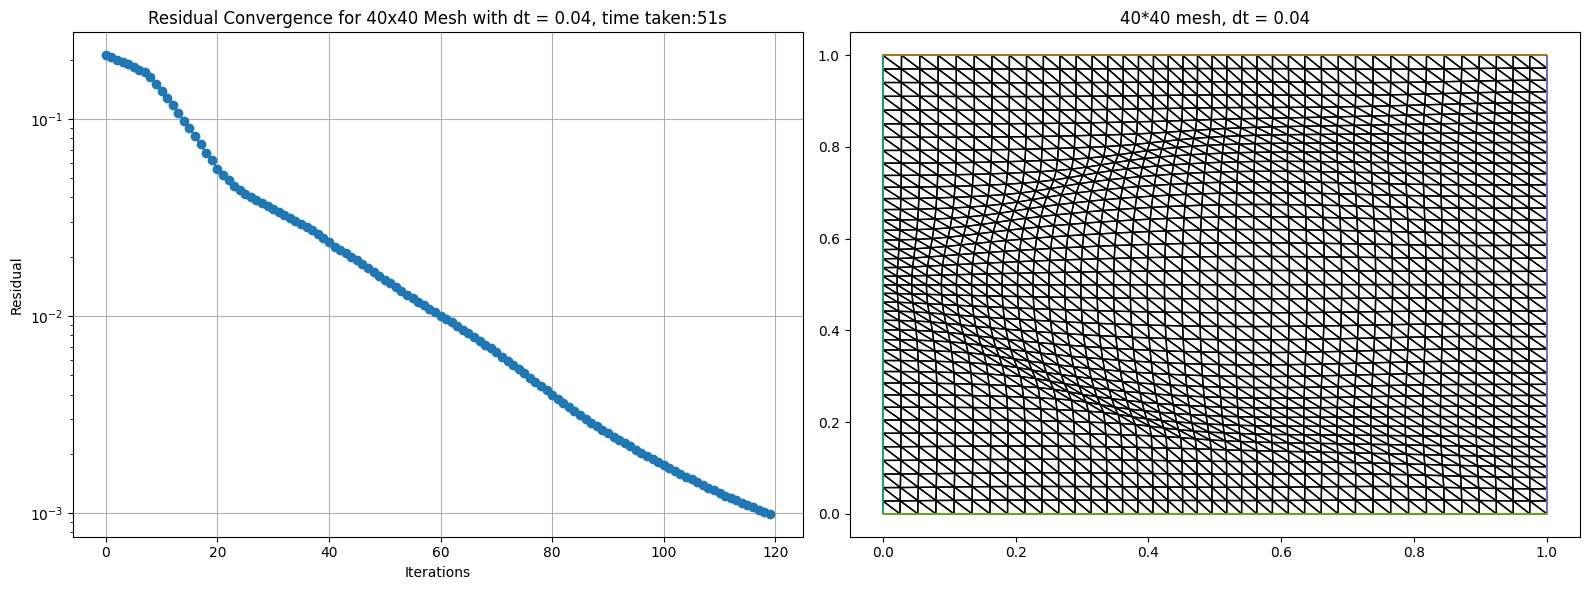

In [29]:
# Read the data
with open("relaxation_converge_smalldt.txt", "r") as f:
    lines = f.readlines()

# Extract the residuals
iterations = []
residuals = []
for line in lines:
    data = line.split()
    iterations.append(int(data[0]))
    residuals.append(float(data[4]))


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot the residual convergence on the first axis
axes[0].plot(iterations, residuals, marker='o', linestyle='-')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residual Convergence for 40x40 Mesh with dt = 0.04, time taken:51s')
axes[0].grid(True)
axes[0].set_yscale('log')

# Plot the mesh on the second axis
triplot(adapted_meshes[0], axes=axes[1])
axes[1].set_title("40*40 mesh, dt = 0.04")
plt.tight_layout()
plt.show()

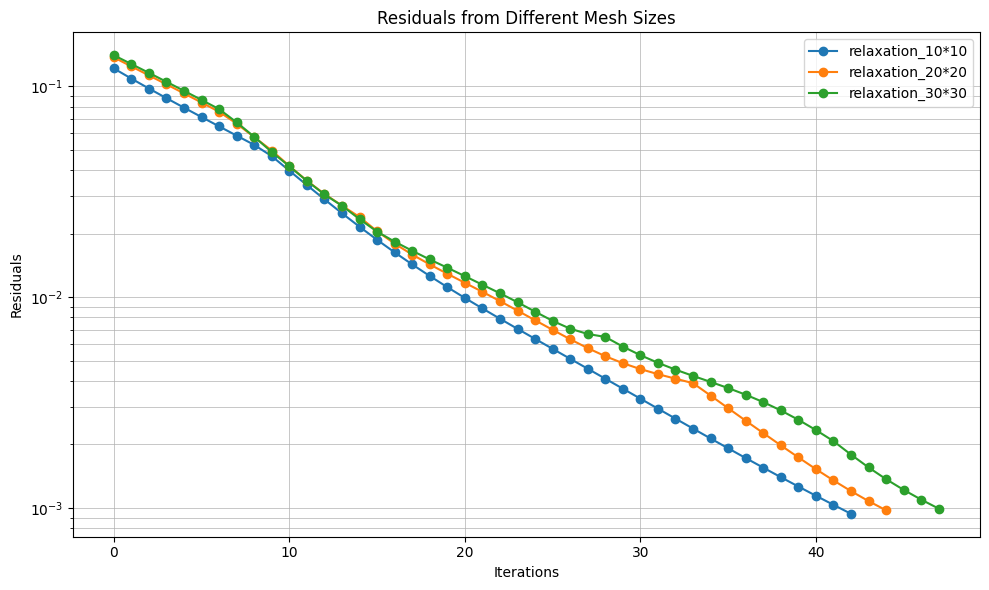

In [33]:
# Create lists to store all iterations and residuals
all_iterations = []
all_residuals = []

# Loop through the range of file names
for i in range(1, 4):
    # Create the file name based on the current index
    filename = f"relaxation_{10*i}*{10*i}.txt"
    
    # Read the data
    with open(filename, "r") as f:
        lines = f.readlines()
    
    # Extract the residuals
    iterations = []
    residuals = []
    for line in lines:
        data = line.split()
        iterations.append(int(data[0]))
        residuals.append(float(data[4]))
    
    # Store the extracted iterations and residuals in the overall lists
    all_iterations.append(iterations)
    all_residuals.append(residuals)

# At the end of this loop:
# all_iterations[i] contains the iterations for the i-th file
# all_residuals[i] contains the residuals for the i-th file

# Create a new plot
plt.figure(figsize=(10, 6))

# Loop through the data and plot each set
for i in range(len(all_iterations)):
    label_name = f"relaxation_{10*(i+1)}*{10*(i+1)}"
    plt.plot(all_iterations[i], all_residuals[i], label=label_name, marker='o', linestyle='-')

# Add title, labels, legend, etc.
plt.title("Residuals from Different Mesh Sizes")
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.yscale("log")  # if you want a logarithmic scale for residuals
plt.legend()
plt.grid(True, which="both", linestyle="-", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()
